# Labeller

In [1]:
import numpy as np


def driver(signal_df, n_components=3, signal_column='Open'):
    # iterate over unique days in the df
    dates = signal_df.Date.unique()
    label_arr = np.zeros((signal_df.shape[0], 2))
    label_arr[:, 0] = signal_df.EpochTime.values
    for d_idx in range(len(dates)):
        # filter on this date
        this_date = dates[d_idx]
        insert_idx = (signal_df['Date'] == this_date)
        signal = signal_df[signal_column].loc[insert_idx].values

        # compute search space for signal
        search_space = compute_search_space(signal)

        # compute growth/decay function and coefficients
        exp_func, _ = compute_growth_coeff(signal, search_space)

        # remove behavior from signal
        no_growth_signal = signal - exp_func

        # compute FFT on growth-less signal
        fft_signal, _ = compute_fft(no_growth_signal, n_components)

        # combine for final signal
        final_signal = exp_func + fft_signal

        # compute differentials of the clean signal to obtain our labels
        clean_signal_diff = np.gradient(final_signal)

        # all points with a positive gradient value are labelled 1
        label_slice = np.zeros((signal.shape[0], 2))
        label_slice[:, 0] = signal_df.EpochTime.values[insert_idx]
        label_slice[clean_signal_diff > 0, 1] = 1
        label_arr[insert_idx] = label_slice

    label_df = pd.DataFrame(label_arr, columns=['EpochTime', 'Label'])
    return label_df


def compute_search_space(signal):
    if signal[-1] > signal[0]:
        # if signal is increasing
        A_values = np.arange(.1, 10.1, .1)
    elif signal[-1] > signal[0]:
        # if signal is decreasing
        A_values = np.arange(-10, 0, .1)
    else:
        # if signal is flat
        A_values = np.arange(-1, 1.1, .1)

    B_values = np.arange(.1, 3.1, .1)

    return np.array(np.meshgrid(A_values, B_values)).T.reshape(-1, 2)


def compute_growth_coeff(signal, search_space):
    # Step 1: Convert the Search Space into a Function Space  ###
    t = np.arange(0, signal.shape[0]).reshape(-1, 1)
    # stack time column vectors into a matrix that's len(time values) x len(combos)
    func_space = np.repeat(t, search_space.shape[0], axis=1)
    # raise time values to B powers in search space
    func_space = func_space ** search_space[:, 1]
    # scale functions by A coefficients
    func_space = search_space[:, 0] * func_space
    # add C term
    func_space += signal[0]

    # Step 2: Compute Error Space
    signal_mat = np.repeat(signal.reshape(-1, 1), search_space.shape[0], axis=1)
    error_space = np.sum(np.abs(signal_mat - func_space), axis=0)

    # Step 3: Find Combo in Search Space w/ Lowest Error
    best_idx = np.argmin(error_space)
    best_combo = search_space[best_idx]
    best_func = func_space[:, best_idx]

    return best_func, [best_combo[0], best_combo[1], signal[0]]


def compute_fft(signal, n_components=8):
    # compute FFT on signal
    n = signal.shape[0]  # get length of signal
    fhat = np.fft.fft(signal, n)  # compute FFT on noisy data
    PSD = fhat * np.conj(fhat) / n  # power spectral density -- multiply complex term by its conjugate and divide by n

    # compute values from FFT
    freq = (1 / n) * np.arange(n)  # frequency from full FFT
    amp = 2 / n * np.abs(fhat)  # amplitude from full FFT
    phase_shift = np.angle(fhat)  # phase shift from full FFT

    # down-sample the computed values from the full FFT
    L = np.arange(1, np.floor(n / 2), dtype='int')
    PSD_reduced = PSD[L]
    freq_reduced = freq[L]
    amp_reduced = amp[L]
    phase_shift_reduced = phase_shift[L]

    # get Fourier Series values
    min_PSD = np.sort(PSD_reduced)[-n_components]
    keep_idx_reduced = PSD_reduced > min_PSD
    freq_clean = freq_reduced[keep_idx_reduced]
    amp_clean = amp_reduced[keep_idx_reduced]
    phase_shift_clean = phase_shift_reduced[keep_idx_reduced]

    # compute inverse FFT for Clean Signal
    keep_idx_full = PSD > min_PSD
    fhat_clean = fhat * keep_idx_full
    fft_clean_signal = np.real(np.fft.ifft(fhat_clean))

    return fft_clean_signal, [amp_clean, freq_clean, phase_shift_clean]



# Plotting

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def plot_label_over_signal(signal_df, label_df, signal_column='Open'):
    # set initial variables
    colors = {'0': 'red', '1': 'green'}
    t = np.arange(signal_df.shape[0])
    classes = label_df['Label'].unique().astype(int)

    # create plot and plot raw signal
    plt.figure()
    plt.title(f'{signal_df.Date.values[0]} - {signal_df.Date.values[-1]}')
    plt.plot(t, signal_df[signal_column].values)

    # plot label values over the signal
    for c_idx in classes:
        # filter on class values
        label_df_slice = label_df.loc[label_df['Label'].values == classes[int(c_idx)]]
        # plot
        plot_idx = np.in1d(signal_df.EpochTime.values, label_df_slice.EpochTime.values)
        plt.scatter(t[plot_idx],
                    signal_df[signal_column].values[plot_idx],
                    color=colors[str(classes[int(c_idx)])],
                    alpha=.5)

    return plt

# Driver

/var/folders/d4/gzxkzs0j3l7b25wvq8qxmj_80000gn/T/ipykernel_79708/4039924261.py:21: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  plot_idx = np.in1d(signal_df.EpochTime.values, label_df_slice.EpochTime.values)


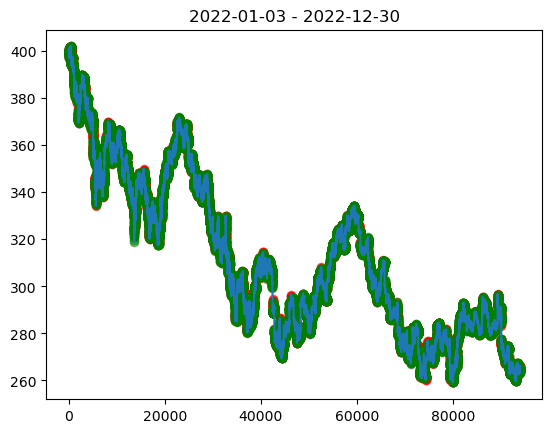

/var/folders/d4/gzxkzs0j3l7b25wvq8qxmj_80000gn/T/ipykernel_79708/1186269343.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_signal_df['DTS'] = pd.to_datetime(raw_signal_df['EpochTime'], unit='s')


,EpochTime,Date,Open
DTS,,,
2022-01-03 14:30:00,1.641220e+09,2022-01-03,399.049988
2022-01-03 14:31:00,1.641220e+09,2022-01-03,399.640015
2022-01-03 14:32:00,1.641220e+09,2022-01-03,400.160004
2022-01-03 14:33:00,1.641220e+09,2022-01-03,400.209991
2022-01-03 14:34:00,1.641220e+09,2022-01-03,400.540009
...,...,...,...
2022-12-30 20:55:00,1.672434e+09,2022-12-30,265.890015
2022-12-30 20:56:00,1.672434e+09,2022-12-30,265.950012
2022-12-30 20:57:00,1.672434e+09,2022-12-30,266.100006


In [3]:
import pandas as pd

df = pd.read_csv('../data/qqq_2022.csv')
sig_col = 'Open'
raw_signal_df = df[['EpochTime', 'Date', sig_col]]  # .loc[df.Date.values == df.Date.unique()[1]]

# component analysis test
c_num = 20
label_df = driver(signal_df=raw_signal_df, n_components=c_num, signal_column=sig_col)
plt = plot_label_over_signal(raw_signal_df, label_df=label_df, signal_column=sig_col)
plt.show()

raw_signal_df['DTS'] = pd.to_datetime(raw_signal_df['EpochTime'], unit='s')
raw_signal_df = raw_signal_df.set_index('DTS')
raw_signal_df

In [4]:
# train_size = int(len(raw_signal_df) * 0.8)
# train, test = raw_signal_df.iloc[:train_size][sig_col], raw_signal_df.iloc[train_size:][sig_col]

data_size = len(raw_signal_df)
train, test = raw_signal_df.iloc[:-30][sig_col], raw_signal_df.iloc[-30:][sig_col]

print(len(train))
print(len(test))

93951
30


In [99]:
print(train)
print()
print(test)

DTS
2022-01-03 14:30:00    399.049988
2022-01-03 14:31:00    399.640015
2022-01-03 14:32:00    400.160004
2022-01-03 14:33:00    400.209991
2022-01-03 14:34:00    400.540009
                          ...    
2022-12-30 20:25:00    264.513397
2022-12-30 20:26:00    264.450012
2022-12-30 20:27:00    264.410004
2022-12-30 20:28:00    264.355011
2022-12-30 20:29:00    264.450012
Name: Open, Length: 93951, dtype: float64

DTS
2022-12-30 20:30:00    264.356506
2022-12-30 20:31:00    264.450012
2022-12-30 20:32:00    264.600006
2022-12-30 20:33:00    264.760010
2022-12-30 20:34:00    264.670013
2022-12-30 20:35:00    264.739990
2022-12-30 20:36:00    264.619904
2022-12-30 20:37:00    264.684998
2022-12-30 20:38:00    264.760010
2022-12-30 20:39:00    264.730011
2022-12-30 20:40:00    264.769989
2022-12-30 20:41:00    264.739990
2022-12-30 20:42:00    264.690002
2022-12-30 20:43:00    264.790009
2022-12-30 20:44:00    264.885010
2022-12-30 20:45:00    264.809998
2022-12-30 20:46:00    265.0499

# ARIMA 1
uses this example: https://analyticsindiamag.com/ai-trends/quick-way-to-find-p-d-and-q-values-for-arima/

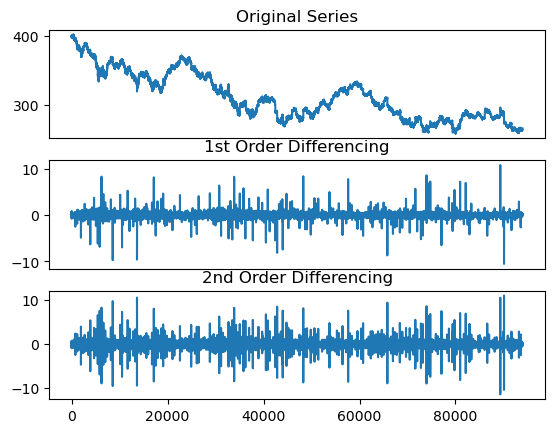

In [5]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(raw_signal_df[[sig_col]])
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)

# 1st Differencing
ax2.plot(raw_signal_df[[sig_col]].diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

# 2nd Differencing
ax3.plot(raw_signal_df[[sig_col]].diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

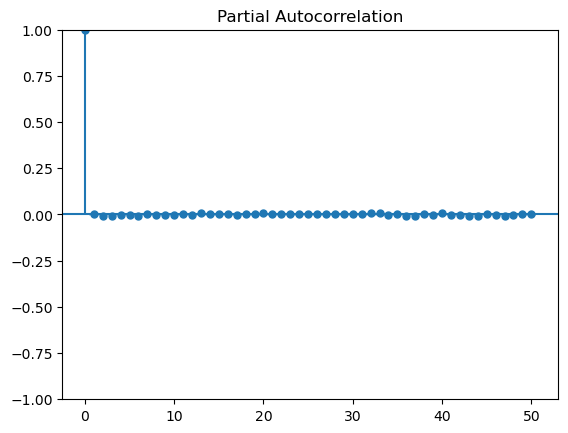

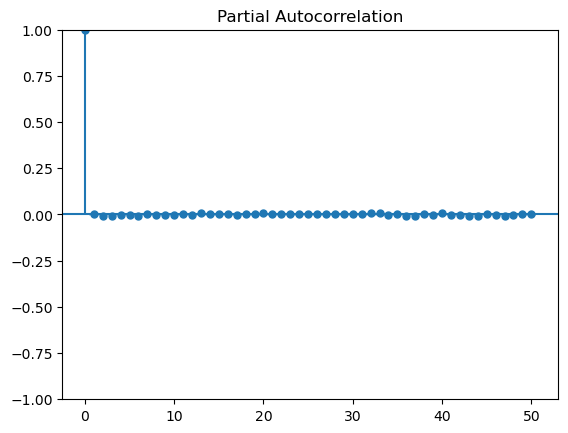

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(raw_signal_df[[sig_col]].diff().dropna())

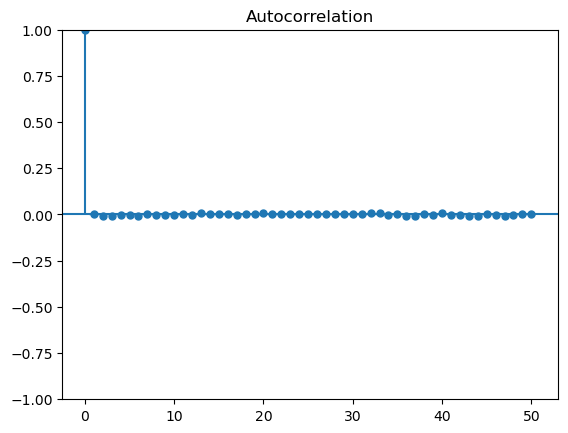

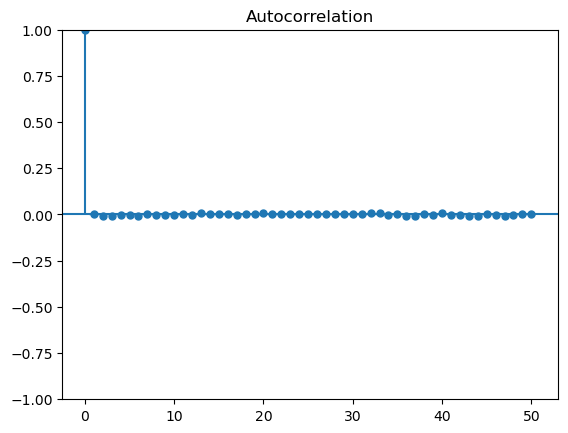

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(raw_signal_df[[sig_col]].diff().dropna())

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

In [134]:
# train_size = int(len(raw_signal_df) * 0.8)
# train, test = raw_signal_df.iloc[:train_size], raw_signal_df.iloc[train_size:]
# # print(len(train))
# # print(len(test))

In [39]:
# Fit ARIMA model
# order contains (p,d,q) where:
#   p = how far back to look to help predict price
#   d = finds the difference between consecutive timestamps
#   q = size of the moving average window
p = 1
d = 1
q = 1
model = ARIMA(train[[sig_col]], order=(p,d,q))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                75184
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -17985.815
Date:                Mon, 03 Mar 2025   AIC                          35973.629
Time:                        17:50:47   BIC                          35982.857
Sample:                             0   HQIC                         35976.466
                              - 75184                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0945   5.76e-05   1639.804      0.000       0.094       0.095
===================================================================================
Ljung-Box (L1) (Q):                   3.16   Jarque-Bera (JB):          62334840.97
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                       144.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# from statsmodels.graphics.tsaplots import plot_predict
# plot_predict(model_fit, dynamic=False)
# plt.show()

In [12]:
# model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [26]:
def diff_inv(series_diff, first_value):
    series_inverted = np.r_[first_value,series_diff].cumsum().astype('float64')
    return series_inverted

In [21]:
test[[sig_col]].to_numpy()[0]
train[[sig_col]].to_numpy()
test[[sig_col]].iloc[0]

Close    273.209991
Name: 75184, dtype: float64

In [32]:
# Forecast
forecast = model_fit.forecast(steps=len(test))
# forecast_dediff = diff_inv(forecast, test[[sig_col]].to_numpy()[0])
x, x_diff = test[sig_col].iloc[0], forecast.iloc[1:]
forecast_dd = np.r_[x, x_diff].cumsum().astype(int)



# forecast
forecast_dd

array([    273,     546,     819, ..., 4865732, 4865976, 4866221],
      shape=(18797,))

In [23]:
test[sig_col]

75184    273.209991
75185    273.239990
75186    272.970001
75187    273.100006
75188    273.220001
            ...    
93976    265.950012
93977    266.105011
93978    266.140106
93979    266.250000
93980    266.334991
Name: Close, Length: 18797, dtype: float64

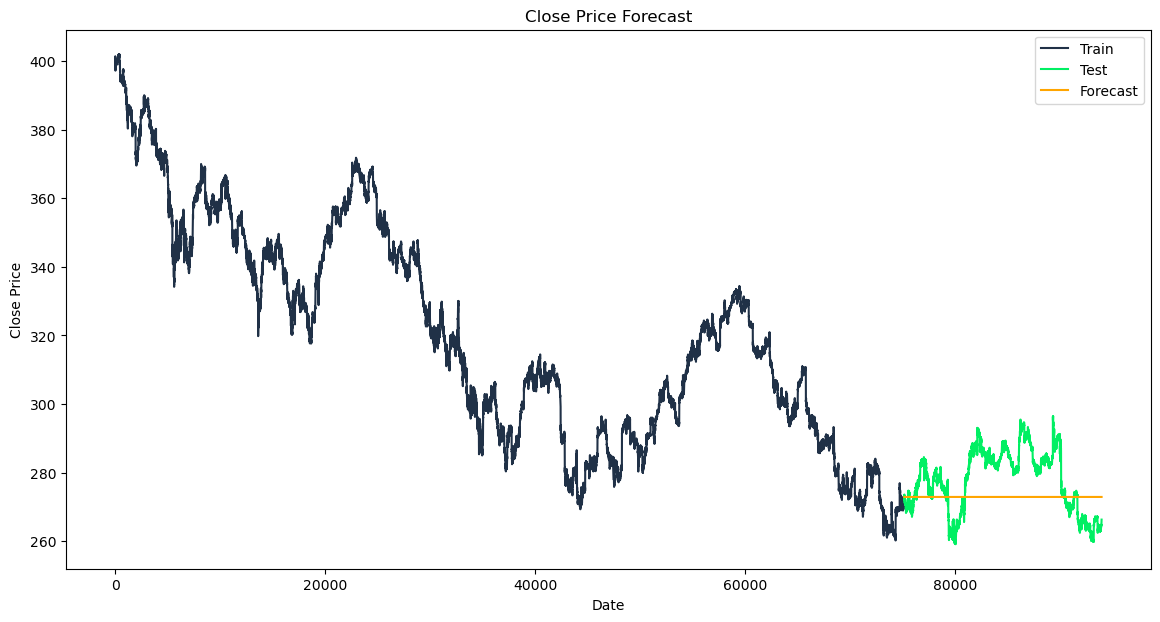

RMSE: 10.2617


In [40]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train[sig_col], label='Train', color='#203147')
plt.plot(test.index, test[sig_col], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title(f'{sig_col} Price Forecast')
plt.xlabel('Date')
plt.ylabel(f'{sig_col} Price')
plt.legend()
plt.show()


forecast_vals = forecast[:len(test)]
test_vals = test[sig_col][:len(forecast)]

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_vals, forecast))
print(f"RMSE: {rmse:.4f}")

In [15]:
forecast

75184    272.940367
75185    272.940354
75186    272.940355
75187    272.940355
75188    272.940355
            ...    
93976    272.940355
93977    272.940355
93978    272.940355
93979    272.940355
93980    272.940355
Name: predicted_mean, Length: 18797, dtype: float64

In [147]:
test['Forecast'] = forecast
test

/var/folders/d4/gzxkzs0j3l7b25wvq8qxmj_80000gn/T/ipykernel_47500/1389005052.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = forecast


,EpochTime,Date,Close,Forecast
75184,1.666189e+09,2022-10-19,273.209991,272.932090
75185,1.666189e+09,2022-10-19,273.239990,272.926917
75186,1.666190e+09,2022-10-19,272.970001,272.925311
75187,1.666190e+09,2022-10-19,273.100006,272.921347
75188,1.666190e+09,2022-10-19,273.220001,272.917520
...,...,...,...,...
93976,1.672434e+09,2022-12-30,265.950012,272.917770
93977,1.672434e+09,2022-12-30,266.105011,272.917770
93978,1.672434e+09,2022-12-30,266.140106,272.917770
93979,1.672434e+09,2022-12-30,266.250000,272.917770


# ARIMA 2
uses this example: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [25]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

order_range = list(range(3))
params = list(itertools.product(order_range, order_range, order_range))
params

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [35]:
# convert to index to period based on minutes for ARIMA
train.index = pd.DatetimeIndex(train.index).to_period('min')
train.index

PeriodIndex(['2022-01-03 14:30', '2022-01-03 14:31', '2022-01-03 14:32',
             '2022-01-03 14:33', '2022-01-03 14:34', '2022-01-03 14:35',
             '2022-01-03 14:36', '2022-01-03 14:37', '2022-01-03 14:38',
             '2022-01-03 14:39',
             ...
             '2022-12-30 20:20', '2022-12-30 20:21', '2022-12-30 20:22',
             '2022-12-30 20:23', '2022-12-30 20:24', '2022-12-30 20:25',
             '2022-12-30 20:26', '2022-12-30 20:27', '2022-12-30 20:28',
             '2022-12-30 20:29'],
            dtype='period[min]', name='DTS', length=93951)

In [70]:
# train.index = train.index.to_timestamp()
# train.index

DatetimeIndex(['2022-01-03 14:30:00', '2022-01-03 14:31:00',
               '2022-01-03 14:32:00', '2022-01-03 14:33:00',
               '2022-01-03 14:34:00', '2022-01-03 14:35:00',
               '2022-01-03 14:36:00', '2022-01-03 14:37:00',
               '2022-01-03 14:38:00', '2022-01-03 14:39:00',
               ...
               '2022-10-19 14:13:00', '2022-10-19 14:14:00',
               '2022-10-19 14:15:00', '2022-10-19 14:16:00',
               '2022-10-19 14:17:00', '2022-10-19 14:18:00',
               '2022-10-19 14:19:00', '2022-10-19 14:20:00',
               '2022-10-19 14:21:00', '2022-10-19 14:22:00'],
              dtype='datetime64[ns]', name='DTS', length=75184, freq=None)

In [36]:
from statsmodels.tsa.arima.model import ARIMA
grid_search = []

for param in params:
    mod = ARIMA(train, order=param, enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    grid_search.append((param, results.aic, results.bic))
    print(f'ARIMA{param} - AIC:{results.aic} - BIC:{results.bic}')

ARIMA(0, 0, 0) - AIC:927105.304160166 - BIC:927124.2051961756


/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1) - AIC:798076.3283243666 - BIC:798104.679846449
ARIMA(0, 0, 2) - AIC:678611.8076691863 - BIC:678649.609656053
ARIMA(0, 1, 0) - AIC:39315.23510882797 - BIC:39324.68561618879
ARIMA(0, 1, 1) - AIC:39316.38654668339 - BIC:39335.287540116784
ARIMA(0, 1, 2) - AIC:39310.73995556101 - BIC:39339.09141377837


/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 0) - AIC:104071.98926467984 - BIC:104081.43976139654
ARIMA(0, 2, 1) - AIC:39329.82350348947 - BIC:39348.72447563437
ARIMA(0, 2, 2) - AIC:39328.511158070556 - BIC:39356.86258435485
ARIMA(1, 0, 0) - AIC:39316.61053921525 - BIC:39344.96209322978
ARIMA(1, 0, 1) - AIC:39314.65088314852 - BIC:39352.45291259182
ARIMA(1, 0, 2) - AIC:39309.96135400072 - BIC:39357.2138375842
ARIMA(1, 1, 0) - AIC:39315.832874418484 - BIC:39334.73388914014
ARIMA(1, 1, 1) - AIC:39319.558174441765 - BIC:39347.909664591854
ARIMA(1, 1, 2) - AIC:39303.498710770524 - BIC:39341.30065506034


/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 0) - AIC:77835.50464201169 - BIC:77854.40563544507
ARIMA(1, 2, 1) - AIC:39328.76380496762 - BIC:39357.115263184976
ARIMA(1, 2, 2) - AIC:39330.08676174315 - BIC:39367.88866345554
ARIMA(2, 0, 0) - AIC:39314.6748393498 - BIC:39352.4768687931
ARIMA(2, 0, 1) - AIC:39315.03963367477 - BIC:39362.2921704789
ARIMA(2, 0, 2) - AIC:39302.88677374939 - BIC:39359.58975404957
ARIMA(2, 1, 0) - AIC:39311.10150070788 - BIC:39339.45299085797
ARIMA(2, 1, 1) - AIC:39303.8784773693 - BIC:39341.68046423608
ARIMA(2, 1, 2) - AIC:39305.80122218557 - BIC:39353.05365254783
ARIMA(2, 2, 0) - AIC:66887.96132240043 - BIC:66916.3127806178
ARIMA(2, 2, 1) - AIC:39324.538225302465 - BIC:39362.34016959228
ARIMA(2, 2, 2) - AIC:39331.581734084204 - BIC:39378.83411122469


In [38]:
best_model = sorted(grid_search, key = lambda x: x[1])[0]
best_order = best_model[0]

print(f'Best ARIMA model: {best_model}\nBest ARIMA order: {best_order}')

Best ARIMA model: ((2, 0, 2), np.float64(39302.88677374939), np.float64(39359.58975404957))
Best ARIMA order: (2, 0, 2)


In [39]:
# train.values[len(train)//2:]
# len(train)

In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

history = train.values.tolist()
print('Loaded history.')

predictions = list()
test_vals = test.values

compute_times = []

print('Starting forecasting.')
for epoch,t in enumerate(range(len(test))):
    start = time.time()
    model = ARIMA(history, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    end = time.time()
    compute_times.append(end-start)
    print(f'epoch={epoch}, predicted={yhat}, observed={obs}, compute time={end-start}')

print(f'Total train time: {sum(compute_times)}')

# evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

Loaded history.
Starting forecasting.


/var/folders/d4/gzxkzs0j3l7b25wvq8qxmj_80000gn/T/ipykernel_65097/1407067691.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


epoch=0, predicted=264.3584570071298, observed=264.4599914550781, compute time=14.937345027923584
epoch=1, predicted=264.4643698007041, observed=264.6099853515625, compute time=16.498628854751587


/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


epoch=2, predicted=264.6133466706883, observed=264.75, compute time=26.35562229156494
epoch=3, predicted=264.75209062057667, observed=264.6300048828125, compute time=15.70263385772705
epoch=4, predicted=264.63031504941705, observed=264.739990234375, compute time=15.056110143661499
epoch=5, predicted=264.7429070872403, observed=264.6158142089844, compute time=16.16897678375244
epoch=6, predicted=264.6170078938937, observed=264.69000244140625, compute time=14.205076932907104
epoch=7, predicted=264.6934671108029, observed=264.7550048828125, compute time=26.107313871383667
epoch=8, predicted=264.7577258829539, observed=264.7214050292969, compute time=14.540519952774048
epoch=9, predicted=264.72335921819445, observed=264.7799987792969, compute time=25.970229148864746
epoch=10, predicted=264.78289064743126, observed=264.75, compute time=15.19788408279419
epoch=11, predicted=264.7521452516736, observed=264.7049865722656, compute time=14.959201097488403
epoch=12, predicted=264.7075834304237, o

/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


epoch=13, predicted=264.7988807116744, observed=264.8699951171875, compute time=26.084412813186646
epoch=14, predicted=264.87267159708557, observed=264.80499267578125, compute time=13.867766857147217
epoch=15, predicted=264.8066844802723, observed=265.04998779296875, compute time=14.139187335968018
epoch=16, predicted=265.0537575078315, observed=265.2099914550781, compute time=15.43521523475647
epoch=17, predicted=265.2113100504672, observed=265.3299865722656, compute time=15.430392026901245
epoch=18, predicted=265.33042389090144, observed=265.3450012207031, compute time=13.952620029449463
epoch=19, predicted=265.34485063017866, observed=265.45001220703125, compute time=13.521492958068848
epoch=20, predicted=265.4509915799463, observed=265.6499938964844, compute time=13.58789873123169
epoch=21, predicted=265.65108340418163, observed=265.7099914550781, compute time=13.438547849655151
epoch=22, predicted=265.709540073282, observed=265.5299987792969, compute time=15.333872318267822


/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


epoch=23, predicted=265.529170766578, observed=265.6400146484375, compute time=27.077680110931396
epoch=24, predicted=265.64278076715544, observed=265.8900146484375, compute time=15.032145023345947
epoch=25, predicted=265.89249280426276, observed=265.95001220703125, compute time=15.039589881896973
epoch=26, predicted=265.949981550066, observed=266.1050109863281, compute time=14.435338020324707
epoch=27, predicted=266.10575985454284, observed=266.1401062011719, compute time=23.731235027313232
epoch=28, predicted=266.13982325436035, observed=266.25, compute time=14.309242248535156
epoch=29, predicted=266.2506684837369, observed=266.3349914550781, compute time=15.235868215560913
Total train time: 511.1962513923645
Test RMSE: 0.12013910206341909


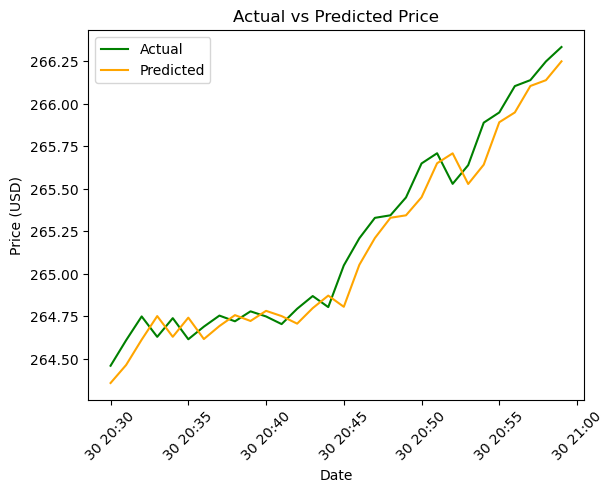

In [41]:
# plot forecasts against actual outcomes
# plt.plot(train.index, train, color='blue', label='Train')
plt.plot(test.index, test, color='green', label='Observed')
plt.plot(test.index, predictions, color='orange', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Actual vs Predicted Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# ARIMA 3

In [42]:
from statsmodels.tsa.arima.model import ARIMA

# create base DF for forecast values
forecast_vals = pd.DataFrame({'day':[], sig_col: []})

# group the current data by DAY
day_df = raw_signal_df[sig_col].groupby(pd.Grouper(freq='D'))

# for each day, fit ARIMA to the observed market data and predict the next open price
for day_data in day_df:
    # get the day
    day = day_data[0]
    # get the day prices
    market_data = day_data[1]

    # no market data on weekends and holidays
    if len(market_data) == 0:
        continue

    # adjust the index so ARIMA knows this is minute by minute data
    market_data.index = pd.DatetimeIndex(market_data.index).to_period('min')

    # build, fit, forecast arima
    day_model = ARIMA(market_data, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
    day_model_fit = day_model.fit()
    next_forecast = day_model_fit.forecast()

    # convert the forecast index to datetime then to day frequency
    next_forecast.index = next_forecast.index.to_timestamp()
    next_forecast.index = pd.DatetimeIndex(next_forecast.index).to_period('D')

    # shift the index to the next day because that's what the forecast is predicting
    forecast_vals.loc[len(forecast_vals)] = [next_forecast.index.shift(1)[0], next_forecast.values[0]]

forecast_vals = forecast_vals.set_index('day')
forecast_vals

/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/info629/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/hom

,Open
day,
2022-01-04,401.487639
2022-01-05,396.951628
2022-01-06,384.849533
2022-01-07,384.052040
2022-01-08,380.366954
...,...
2022-12-24,267.267804
2022-12-28,263.434361
2022-12-29,260.010353


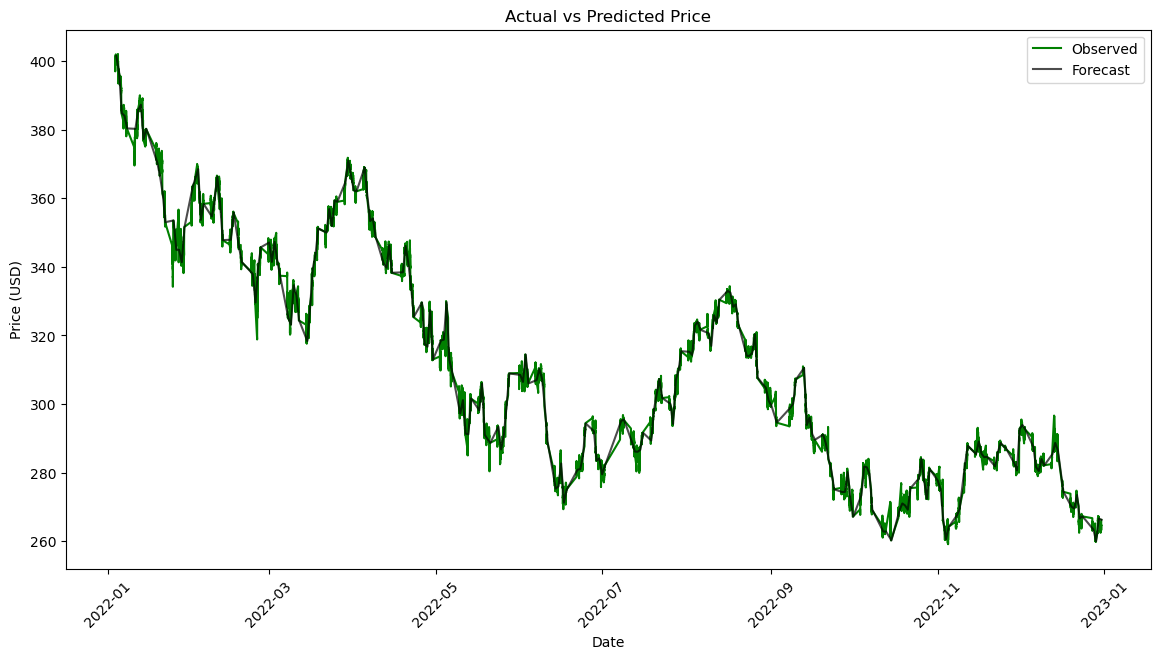

In [43]:
plt.figure(figsize=(14,7))
plt.plot(raw_signal_df.index, raw_signal_df[sig_col], color='green', label='Observed')
plt.plot(forecast_vals.index, forecast_vals, color='black', label='Forecast', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Actual vs Predicted Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [44]:
# Compute the classification of points
diffs = np.diff(forecast_vals.values, axis=0)
yhat = np.where(diffs > 0, 1, 0)
yhat[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0]])

# ARIMA 4
uses this example: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [266]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

In [269]:
# r = 3
# perms = itertools.combinations([0,1,2], r)
vals = list(range(6))
all_permutations = list(itertools.product(vals, vals, vals))
all_permutations

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (0, 4, 5),
 (0, 5, 0),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 5, 4),
 (0, 5, 5),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (1, 4, 5),
 (1, 5, 0),
 (1, 5, 1),
 (1, 5, 2),
 (1, 5, 3),
 (1, 5, 4),
 (1, 5, 5),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 0, 5),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2,

In [270]:
fit_res = []

for param in all_permutations:
    mod = ARIMA(train[sig_col], order=param,enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    fit_res.append((param, results.aic))
    print('ARIMA{} - AIC:{}'.format(param, results.aic))

ARIMA(0, 0, 0) - AIC:735465.1969727273
ARIMA(0, 0, 1) - AIC:632285.7352366977
ARIMA(0, 0, 2) - AIC:537137.3916171708
ARIMA(0, 0, 3) - AIC:456816.7688400685


KeyboardInterrupt: 

In [302]:
best_param = sorted(fit_res, key = lambda x: x[1])[0][0]
best_param
best_param = (20,0,4)

In [303]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

mod = ARIMA(train[sig_col], order=best_param, enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        320.1136        nan        nan        nan         nan         nan
ar.L1       2.497e+09        nan        nan        nan         nan         nan
ar.L2      -1.565e+09        nan        nan        nan         nan         nan
ar.L3      -4.473e+08        nan        nan        nan         nan         nan
ar.L4      -3.358e+08        nan        nan        nan         nan         nan
ar.L5       -1.31e+08        nan        nan        nan         nan         nan
ar.L6       3.851e+06        nan        nan        nan         nan         nan
ar.L7       3.546e+06        nan        nan        nan         nan         nan
ar.L8       -2.43e+07        nan        nan        nan         nan         nan
ar.L9       2.538e+05        nan        nan        nan         nan         nan
ar.L10     -1.224e+06        nan        nan        n

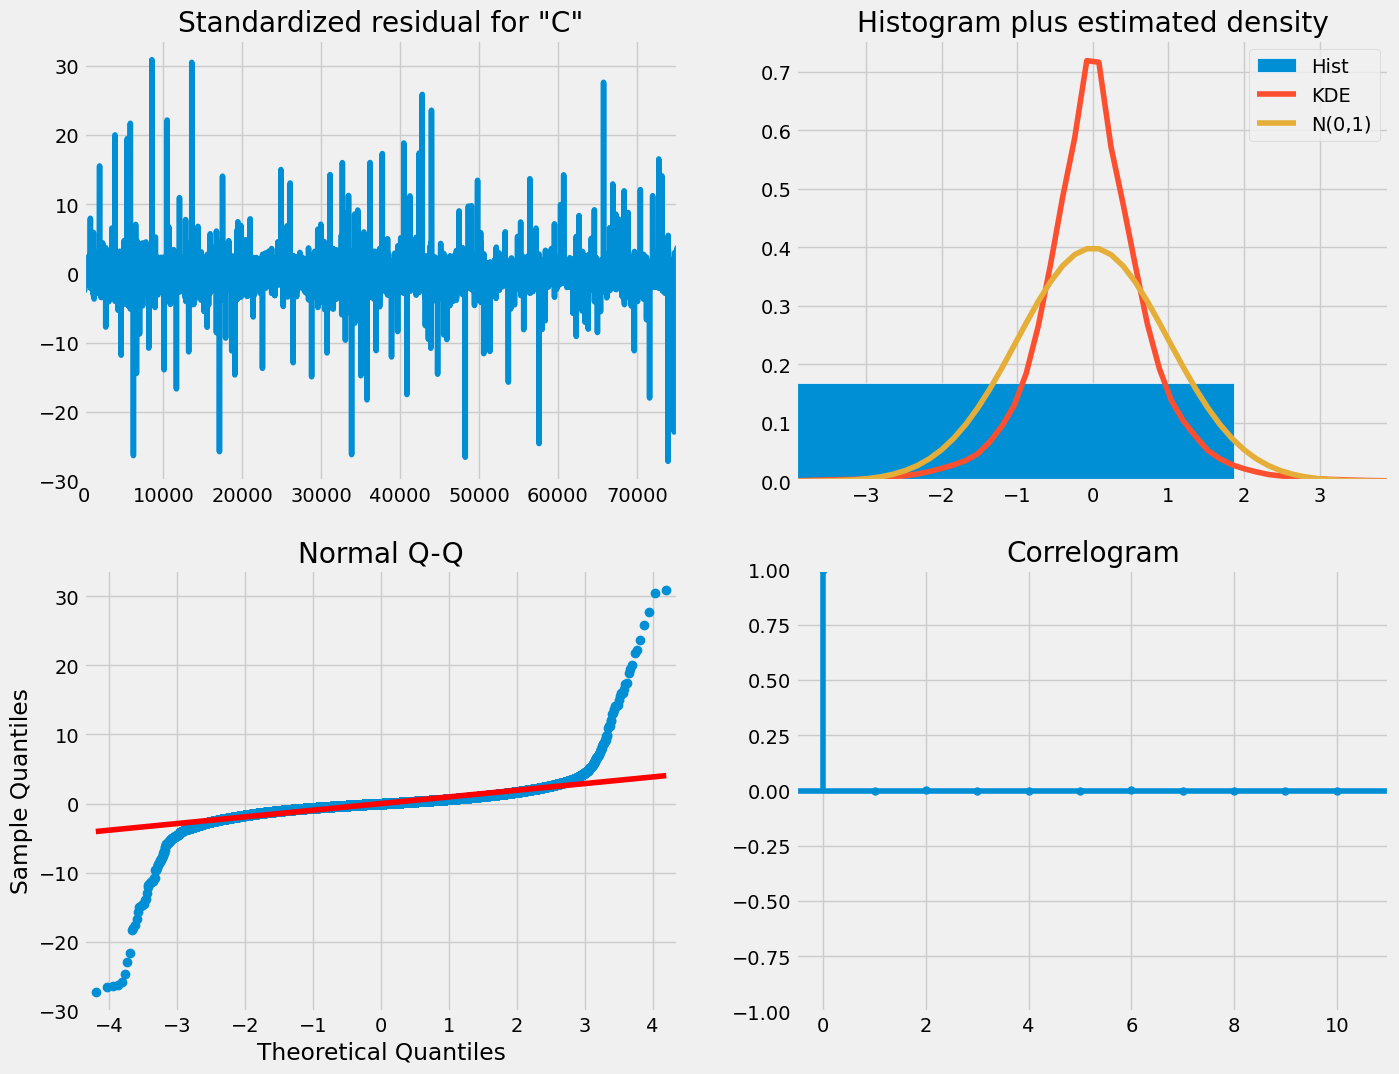

In [304]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [305]:
pred = results.get_prediction(start=len(train), end=len(raw_signal_df), dynamic=False)
# pred = results.get_prediction(dynamic=False)
pred_ci = pred.conf_int()

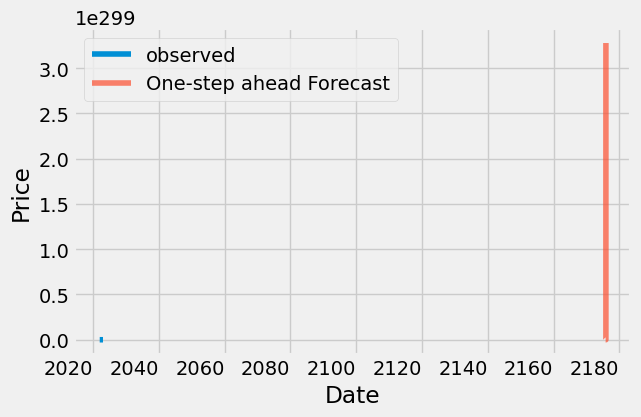

In [306]:
ax = raw_signal_df[sig_col].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [291]:
from collections import Counter
Counter(results.forecast(len(test)))

Counter({272.93765504488994: 1,
         272.9369718740875: 1,
         272.93746821344956: 1,
         272.93939810467134: 1,
         272.94172739536197: 1,
         272.9447362483009: 1,
         272.94784481300417: 1,
         272.95128939128284: 1,
         272.95473254657554: 1,
         272.95834973238294: 1,
         272.9619386122953: 1,
         272.96562187483664: 1,
         272.96927544286734: 1,
         272.9729823689682: 1,
         272.9766653363418: 1,
         272.9803795161103: 1,
         272.9840761916705: 1,
         272.987791596682: 1,
         272.99149480384386: 1,
         272.9952094416967: 1,
         272.99891577784206: 1,
         273.0026291522627: 1,
         273.0063369335985: 1,
         273.0100490525946: 1,
         273.01375740602236: 1,
         273.01746841117256: 1,
         273.0211768623695: 1,
         273.02488690167456: 1,
         273.0285951818003: 1,
         273.0323043742558: 1,
         273.03601232543633: 1,
         273.03972075755

In [292]:
results.predict(start=len(train), end=len(raw_signal_df), dynamic=True)

75184    272.937655
75185    272.936972
75186    272.937468
75187    272.939398
75188    272.941727
            ...    
93977    309.374871
93978    309.375717
93979    309.376562
93980    309.377408
93981    309.378254
Name: predicted_mean, Length: 18798, dtype: float64

In [293]:
train.index[-1]

Timestamp('2022-10-19 14:22:00')

In [307]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=len(test))
# pred_uc = results.get_forecast(steps=pd.to_datetime('2022-12-30 20:59:00'))

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [308]:
# Convert to DataFrame
forecast_df = pd.DataFrame({
    "Forecast": pred_uc.predicted_mean.values
}, index=test.index)

forecast_df

,Forecast
DTS,
2022-10-19 14:23:00,1.571949e+08
2022-10-19 14:24:00,3.924870e+17
2022-10-19 14:25:00,9.799705e+26
2022-10-19 14:26:00,2.446812e+36
2022-10-19 14:27:00,6.109257e+45
...,...
2022-12-30 20:55:00,NaN
2022-12-30 20:56:00,NaN
2022-12-30 20:57:00,NaN


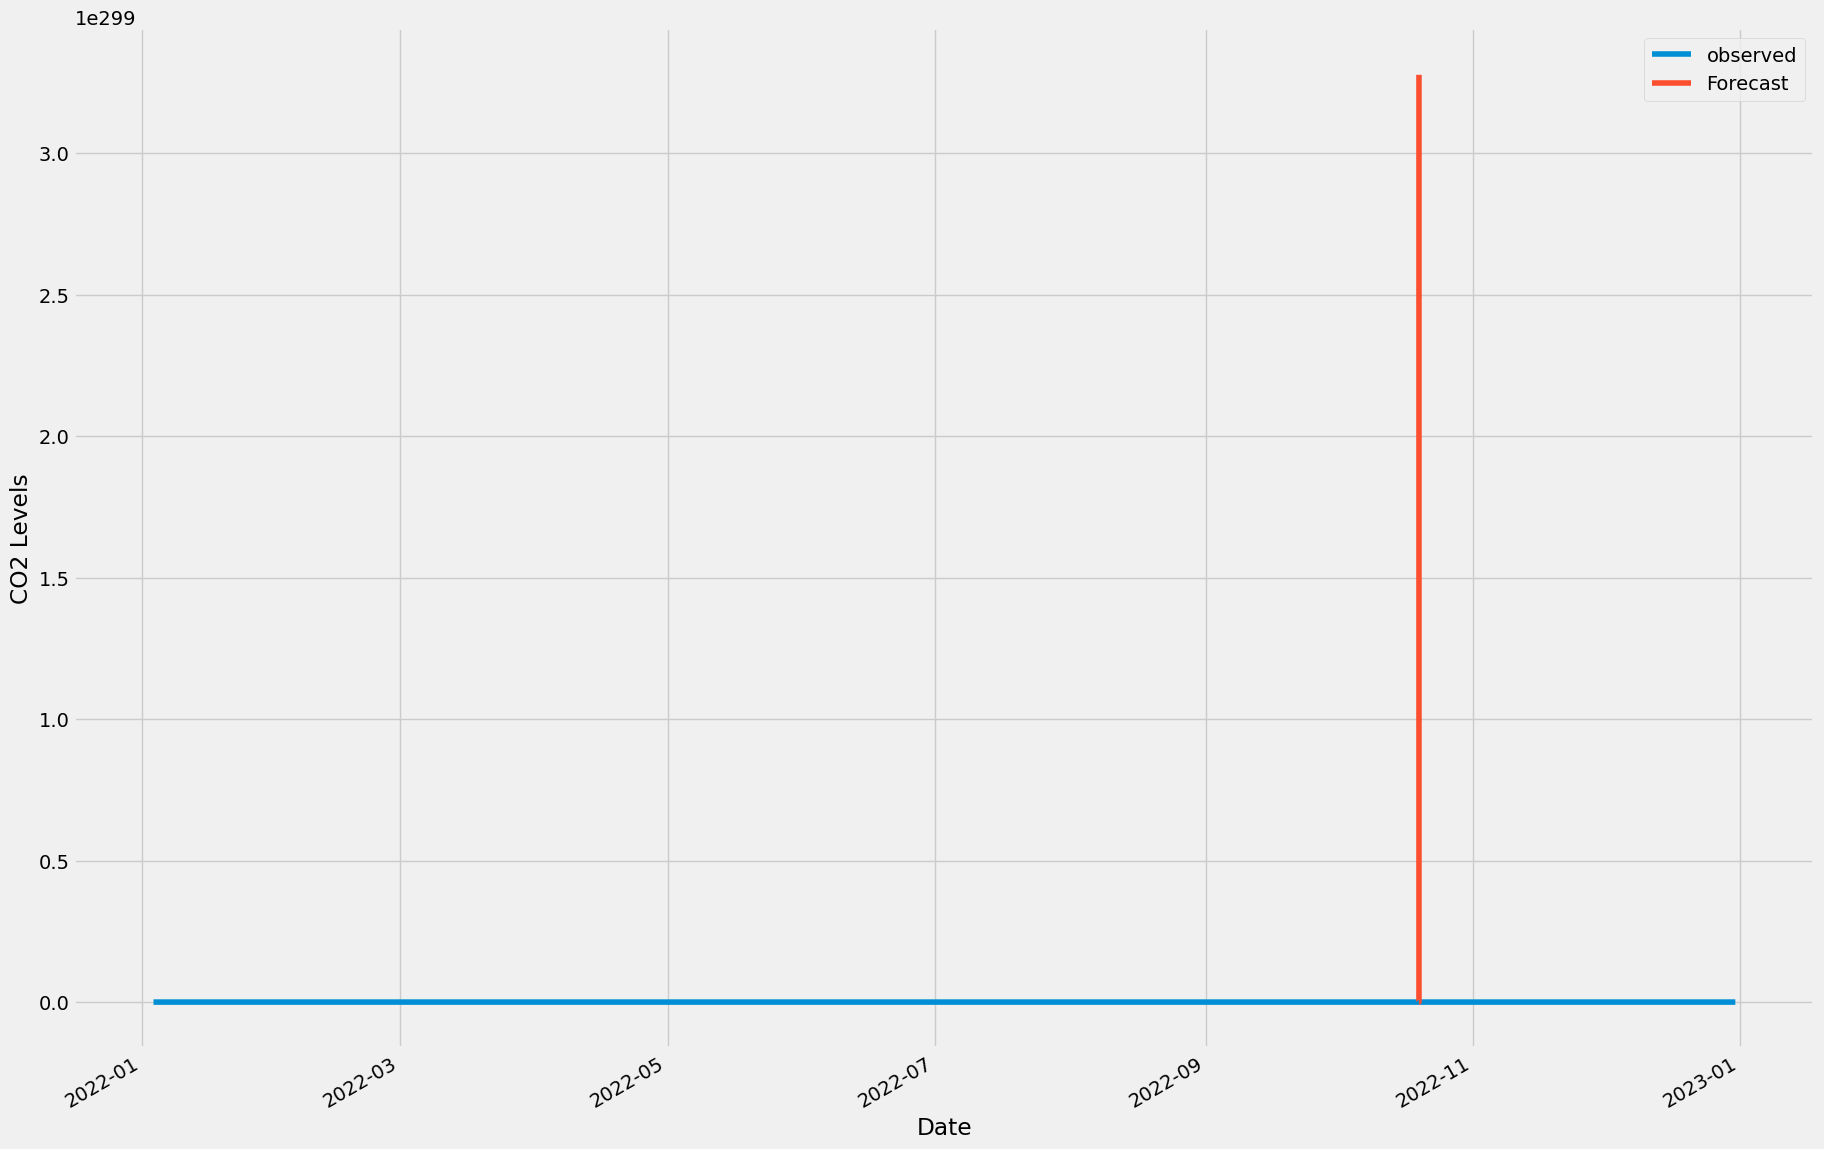

In [309]:


ax = raw_signal_df[sig_col].plot(label='observed', figsize=(20, 15))
forecast_df.Forecast.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()